# Attention Walmart Shoppers
### A Walmart retail analysis

The data was originally retrieved from:
 -   https://www.kaggle.com/rutuspatel/retail-analysis-with-walmart-sales-data
 - https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

### Data Dictionary

| Target       |  Data Type       | Description                     |
|--------------|------------------|---------------------------------|
| Weekly_Sales |   float64        | Sales in USD per week by store  |


| Column        |  Data Type       | Description                                      |  
|---------------|------------------|--------------------------------------------------|
| Store         |     int64        | unique identifier for store  (1-45)              |
| Date          |     object       | Date of transaction                              |
| Holiday_Flag  |     int64        | indicator of a Holiday week (boolean)            |
| Temperature   |     float64      | temperature in Farenheight                       |
| Fuel_Price    |     float64      | cost of fuel(in USD) in region                   |
| CPI           |     float64      | Prevailing consumer price index, cost of goods   |
| Unemployment  |     float64      | Prevailing unemployment rate                     |

## Goal:
- to predict weekly sales price for a store

## Think about...
- What is your goal?
- what is your TARGET? drivers for that target?
- what is one oberservation? what does one row from your dataset represent?

## Daily meetings
- standup doc
- shared knowledge doc

### Three important Questions
- what did you work on since we last talked?
- what are you planning on working on next?
- what are your blockers?

In [1]:
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#custom modules
import wrangle
import new_wrangle

<hr style="border:2px solid black"> </hr>

# Acquire

In [2]:
df= new_wrangle.acquire_data()

In [3]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,A,151315
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,A,151315
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,A,151315
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,A,151315
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,A,151315


In [4]:
#check for nulls, dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
 8   Type          6435 non-null   object 
 9   Size          6435 non-null   int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 553.0+ KB


<hr style="border:2px solid black"> </hr>

# Prepare

In [5]:
#import the cleaned data using new_wrangle.py
df= new_wrangle.wrangle_walmart()

/Users/natasharivers/codeup-data-science/database-exercises/capstone/new_wrangle.py:65: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year'] = pd.DatetimeIndex(df['Date']).week


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store_id         6435 non-null   int64  
 1   weekly_sales     6435 non-null   float64
 2   holiday_flag     6435 non-null   int64  
 3   temperature      6435 non-null   int64  
 4   fuel_price       6435 non-null   float64
 5   CPI              6435 non-null   float64
 6   unemployment     6435 non-null   float64
 7   store_type       6435 non-null   object 
 8   store_size       6435 non-null   int64  
 9   month            6435 non-null   object 
 10  year             6435 non-null   int64  
 11  quarter          6435 non-null   int64  
 12  weekday          6435 non-null   object 
 13  week_of_year     6435 non-null   int64  
 14  deflated_series  6435 non-null   float64
 15  sales_delta      6435 non-null   float64
 16  gas_delta        6435 non-null   float64
 

In [7]:
#take a look at the data
df.tail()

,store_id,weekly_sales,holiday_flag,temperature,fuel_price,CPI,unemployment,store_type,store_size,month,year,quarter,weekday,week_of_year,deflated_series,sales_delta,gas_delta,season,holiday_name
Date,,,,,,,,,,,,,,,,,,,
2012-10-26,25,688940.94,0,56,3.88,216.152,7.293,B,128107,October,2012,4,Friday,43,3187.30,3409.09,-0.09,Fall,no_holiday
2012-10-26,5,319550.77,0,71,3.51,224.038,5.422,C,34875,October,2012,4,Friday,43,1426.32,6192.62,-0.08,Fall,no_holiday
2012-10-26,40,921264.52,0,49,3.92,138.728,4.145,A,155083,October,2012,4,Friday,43,6640.80,3094.02,-0.08,Fall,no_holiday
2012-10-26,18,1127516.25,0,56,3.92,138.728,8.243,B,120653,October,2012,4,Friday,43,8127.53,78809.50,-0.08,Fall,no_holiday
2012-10-26,45,760281.43,0,58,3.88,192.309,8.667,B,118221,October,2012,4,Friday,43,3953.44,42155.90,-0.09,Fall,no_holiday


In [8]:
#train test split
X_train, y_train, X_test, y_test = new_wrangle.train_test(df,'weekly_sales')

X_train -> (5445, 18)
X_test -> (990, 18)


In [9]:
y_train.head()

Date
2010-02-05    1643690.90
2010-02-05    2193048.75
2010-02-05     536006.73
2010-02-05     789036.02
2010-02-05     465108.52
Name: weekly_sales, dtype: float64

<hr style="border:2px solid black"> </hr>

# Explore

In [10]:
#count of season
df.season.value_counts()

Summer    2925
Winter    1350
Spring    1215
Fall       945
Name: season, dtype: int64

In [11]:
df.holiday_name.value_counts()

no_holiday      5985
labor_day        135
super_bowl       135
christmas         90
thanksgiving      90
Name: holiday_name, dtype: int64

In [12]:
df.quarter.value_counts()

3    1800
2    1755
1    1485
4    1395
Name: quarter, dtype: int64

In [13]:
#bivariate

In [14]:
cat_col = df.select_dtypes(include='object').columns
num_col = df.select_dtypes(include='number').columns

<AxesSubplot:xlabel='store_type', ylabel='store_size'>

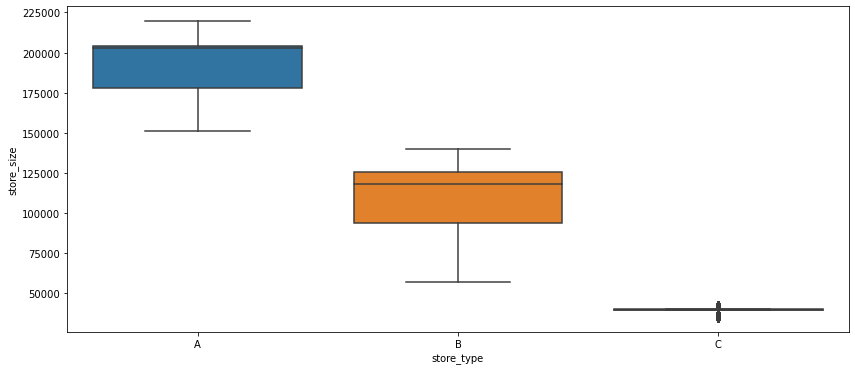

In [15]:
#visualize store_type by store_size
plt.figure(figsize=(14, 6))
sns.boxplot(x='store_type', y='store_size', data=df)

### Takeaways:
- Store A: appears to be only larger stores
- Store B: appear to be midsized stores
- Store C: appears to be only smaller stores

- outliers were addressed (store 3, store 5, store 33, store 36 were classified incorrectly)

In [16]:
#correct outlier store_types
def address_outliers():
    df[df['store_id'] ==3] = df.loc[df['store_id'] == 3].replace({'B':'C'})
    df[df['store_id'] ==5] = df.loc[df['store_id'] == 5].replace({'B':'C'})
    df[df['store_id'] ==33] = df.loc[df['store_id'] == 33].replace({'A':'C'})
    df[df['store_id'] ==36] = df.loc[df['store_id'] == 36].replace({'A':'C'})

    return df

In [17]:
df2= address_outliers()

In [18]:
df2.loc[df2['store_id'] == 3]

,store_id,weekly_sales,holiday_flag,temperature,fuel_price,CPI,unemployment,store_type,store_size,month,year,quarter,weekday,week_of_year,deflated_series,sales_delta,gas_delta,season,holiday_name
Date,,,,,,,,,,,,,,,,,,,
2010-02-05,3,461622.22,0,45,2.57,214.425,7.368,C,37392,February,2010,1,Friday,5,2152.84,0.00,0.00,Winter,no_holiday
2010-02-12,3,420728.96,1,47,2.55,214.575,7.368,C,37392,February,2010,1,Friday,6,1960.75,-40893.26,-0.02,Winter,super_bowl
2010-02-19,3,421642.19,0,47,2.51,214.620,7.368,C,37392,February,2010,1,Friday,7,1964.60,913.23,-0.04,Winter,no_holiday
2010-02-26,3,407204.86,0,52,2.56,214.648,7.368,C,37392,February,2010,1,Friday,8,1897.08,-14437.33,0.05,Winter,no_holiday
2010-03-05,3,415202.04,0,53,2.62,214.675,7.368,C,37392,March,2010,1,Friday,9,1934.10,7997.18,0.06,Spring,no_holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,3,389813.02,0,77,3.67,226.518,6.334,C,37392,September,2012,3,Friday,39,1720.89,-24579.07,-0.05,Summer,no_holiday
2012-10-05,3,443557.65,0,72,3.62,226.721,6.034,C,37392,October,2012,4,Friday,40,1956.40,53744.63,-0.05,Fall,no_holiday
2012-10-12,3,410804.39,0,70,3.60,226.924,6.034,C,37392,October,2012,4,Friday,41,1810.32,-32753.26,-0.02,Fall,no_holiday


In [19]:
[df['store_id'] ==5] = df.loc[df['store_id'] == 5].replace({'B':'C'})
[df['store_id'] ==33] = df.loc[df['store_id'] == 33].replace({'A':'C'})
[df['store_id'] ==36] = df.loc[df['store_id'] == 36].replace({'A':'C'})

SyntaxError: cannot assign to comparison (<ipython-input-19-f2d6a90f1932>, line 1)

In [ ]:
df2= address_outliers(df)

In [ ]:
plt.figure(figsize=(14,6))
sns.boxplot(x='store_type', y='weekly_sales', data=df)